Okay first thing's first, let's get the prerequisites installed. Aerosandbox will provide the simulation environment, and baseline will include gym and the related requirements for training a model to optimize within that simulation.

🚨 Using Python 3.9.6 (3.11.x has compatability issues with AeroSandbox)

In [1]:
# Install a pip package in the current Jupyter kernel
import sys

!{sys.executable} -m pip install 'aerosandbox[full]'
!{sys.executable} -m pip install "gymnasium[all]"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-0.2.1-py3-none-any.whl (25 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.1.0
    Uninstalling Shimmy-1.1.0:
      Successfully uninstalled Shimmy-1.1.0
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


Alright let's set up the custom environment

First let's instantiate a plane with basic geometry:

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np
#HYPERPARAMS
dX_bounds = (-0.1, .1) 
dY_bounds = (-0.1, 0.1)
dZ_bounds = (-0.1, 0.1)
dChord_bounds = (-0.1, 0.1)
dTwist_bounds = (-1, 1)
KT_bounds = (9, 10)
KB_bounds = (-3, -2)
N_bounds = (1, 10)
LEW_bounds = (1, 1)

numChords = 4
kulfanWeightResolution = 6

# Lower and upper bounds for each of the parameters
low = np.array([dX_bounds[0], dY_bounds[0], dZ_bounds[0], dChord_bounds[0], dTwist_bounds[0]] + [KT_bounds[0]]*kulfanWeightResolution + [KB_bounds[0]]*kulfanWeightResolution + [N_bounds[0], N_bounds[0], LEW_bounds[0]], dtype=np.float32)
high = np.array([dX_bounds[1], dY_bounds[1], dZ_bounds[1], dChord_bounds[1], dTwist_bounds[1]] + [KT_bounds[1]]*kulfanWeightResolution + [KB_bounds[1]]*kulfanWeightResolution + [N_bounds[1], N_bounds[1], LEW_bounds[1]], dtype=np.float32)
vectorLengthPerXSec = len(low)
# Since you have 9 vectors, the action space will be:
low = np.tile(low, numChords)  # Repeating the pattern 9 times
high = np.tile(high, numChords)

In [3]:

import gymnasium as gym
from gymnasium import spaces
import numpy as np
	
class AeroEnv(gym.Env):
	"""Custom Environment that follows gym interface"""

	def __init__(self):
		super(AeroEnv, self).__init__()

		# Initial values for cross sections
		self.init_xyz_le = [[0, i, 0] for i in range(numChords)]
		self.init_chord = [1] * numChords  														
		self.init_twist = [0] * numChords  														
		self.init_upper_weights = [np.array([1] * kulfanWeightResolution,np.float32) for _ in range(numChords)]
		self.init_lower_weights = [np.array([0.5] * kulfanWeightResolution,np.float32) for _ in range(numChords)]
		self.init_leading_edge_weight = [0] * numChords  										
		self.init_N1 = [1] * numChords 															
		self.init_N2 = [1] * numChords

		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],        # Reference for moments
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)
		
		#Initialize action space
		action_space = spaces.Box(low=low, high=high, dtype=np.float32)
		self.action_space = action_space
		self.observation_space = spaces.Box(low=np.array([-10,-10], np.float32), high=np.array([-10,-10], np.float32), # lift coefficient, drag coefficient
											dtype=np.float32)

	def step(self, action):
		for i in range(numChords):
			idx = i * vectorLengthPerXSec

			# Apply dX, dY, dZ
			newXYZ_le = [
				self.xsecs[i].xyz_le[0] + action[idx], 		#x + dx
				self.xsecs[i].xyz_le[1] + action[idx + 1],	#y + dy
				self.xsecs[i].xyz_le[2] + action[idx + 2]	#z + dz
			]
			# Apply dChord, dTwist
			newChord = self.xsecs[i].chord + action[idx + 3] #chord + dchord
			newTwist = self.xsecs[i].twist + action[idx + 4]

			# Set KB, KT 
			newUpper_weights = np.array([action[idx + 5 + j] for j in range(kulfanWeightResolution)], np.float32)
			newLower_weights = np.array([action[idx + 5+kulfanWeightResolution + j] for j in range(kulfanWeightResolution)], np.float32)
			
			# Set LEW, N1, N2
			newLeading_edge_weight = action[idx + 5+2*kulfanWeightResolution] 	# LEW = action's LEW
			newN1 = action[idx + 6+2*kulfanWeightResolution] 					# N1 = action's N1
			newN2 = action[idx + 7+2*kulfanWeightResolution]					# N2 = action's N2

			self.xsecs[i] = asb.WingXSec(
				xyz_le= ([0,0,0] if i == 0 else newXYZ_le),
				chord=newChord,
				twist=newTwist,
				airfoil=asb.KulfanAirfoil(
					leading_edge_weight=newLeading_edge_weight,
					lower_weights=newLower_weights,
					upper_weights=newUpper_weights,
					N1=newN1,
					N2=newN2
				)
			)

		
		self.airplane = asb.Airplane(
			name="TestPlane",
			xyz_ref=[0, 0, 0],
			wings=[asb.Wing(
					name="Wing",    
					symmetric=True,
					xsecs=self.xsecs
				)],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()  # Returns a dictionary
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		obs = [liftCoeff, dragCoeff]
		reward = liftCoeff/dragCoeff
		terminated = bool(reward >= 120)
		truncated = bool(reward >= 120)
		info = {"lift": liftCoeff, "drag": dragCoeff}

		return obs, reward, terminated, truncated, info #last array here is the info object
    # observation (ObsType): An element of the environment's observation_space as the next observation due to the agent actions.
    # reward (SupportsFloat): The reward as a result of taking the action.
    # terminated (bool): Whether the agent reaches the terminal state (as defined under the MDP of the task)
    # truncated (bool): Whether the truncation condition outside the scope of the MDP is satisfied.
    # info (dict): Contains auxiliary diagnostic information (helpful for debugging, learning, and logging).
	
	def reset(self, seed):
		# Reinitialize wing sections to their initial states
		self.xsecs = [asb.WingXSec(
			xyz_le=self.init_xyz_le[i],
			chord=self.init_chord[i],
			twist=self.init_twist[i],
			airfoil=asb.KulfanAirfoil(
				upper_weights=self.init_upper_weights[i],
				lower_weights=self.init_lower_weights[i],
				leading_edge_weight=self.init_leading_edge_weight[i],
				N1=self.init_N1[i],
				N2=self.init_N2[i]
			)
		) for i in range(numChords)]

		self.airplane = asb.Airplane(
			name="TestPlane(JustWings)",
			xyz_ref=[0, 0, 0],
			wings=[
				asb.Wing(
					name="Wing",    
					symmetric=True,            
					xsecs=self.xsecs
				),
			],
		)

		self.vlm = asb.VortexLatticeMethod(
			airplane=self.airplane,
			op_point=asb.OperatingPoint(
				velocity=22.22,  # 80kph
				alpha=0,  # degree
			)
		)
		aero = self.vlm.run()
		liftCoeff = aero["CL"]
		dragCoeff = aero["CD"]
		
		return [liftCoeff, dragCoeff], {"lift": liftCoeff, "drag": dragCoeff} 
	
	def render(self):
		self.vlm.run()
		self.airplane.draw_three_view()
		self.vlm.draw()
	
	def close (self):
		...

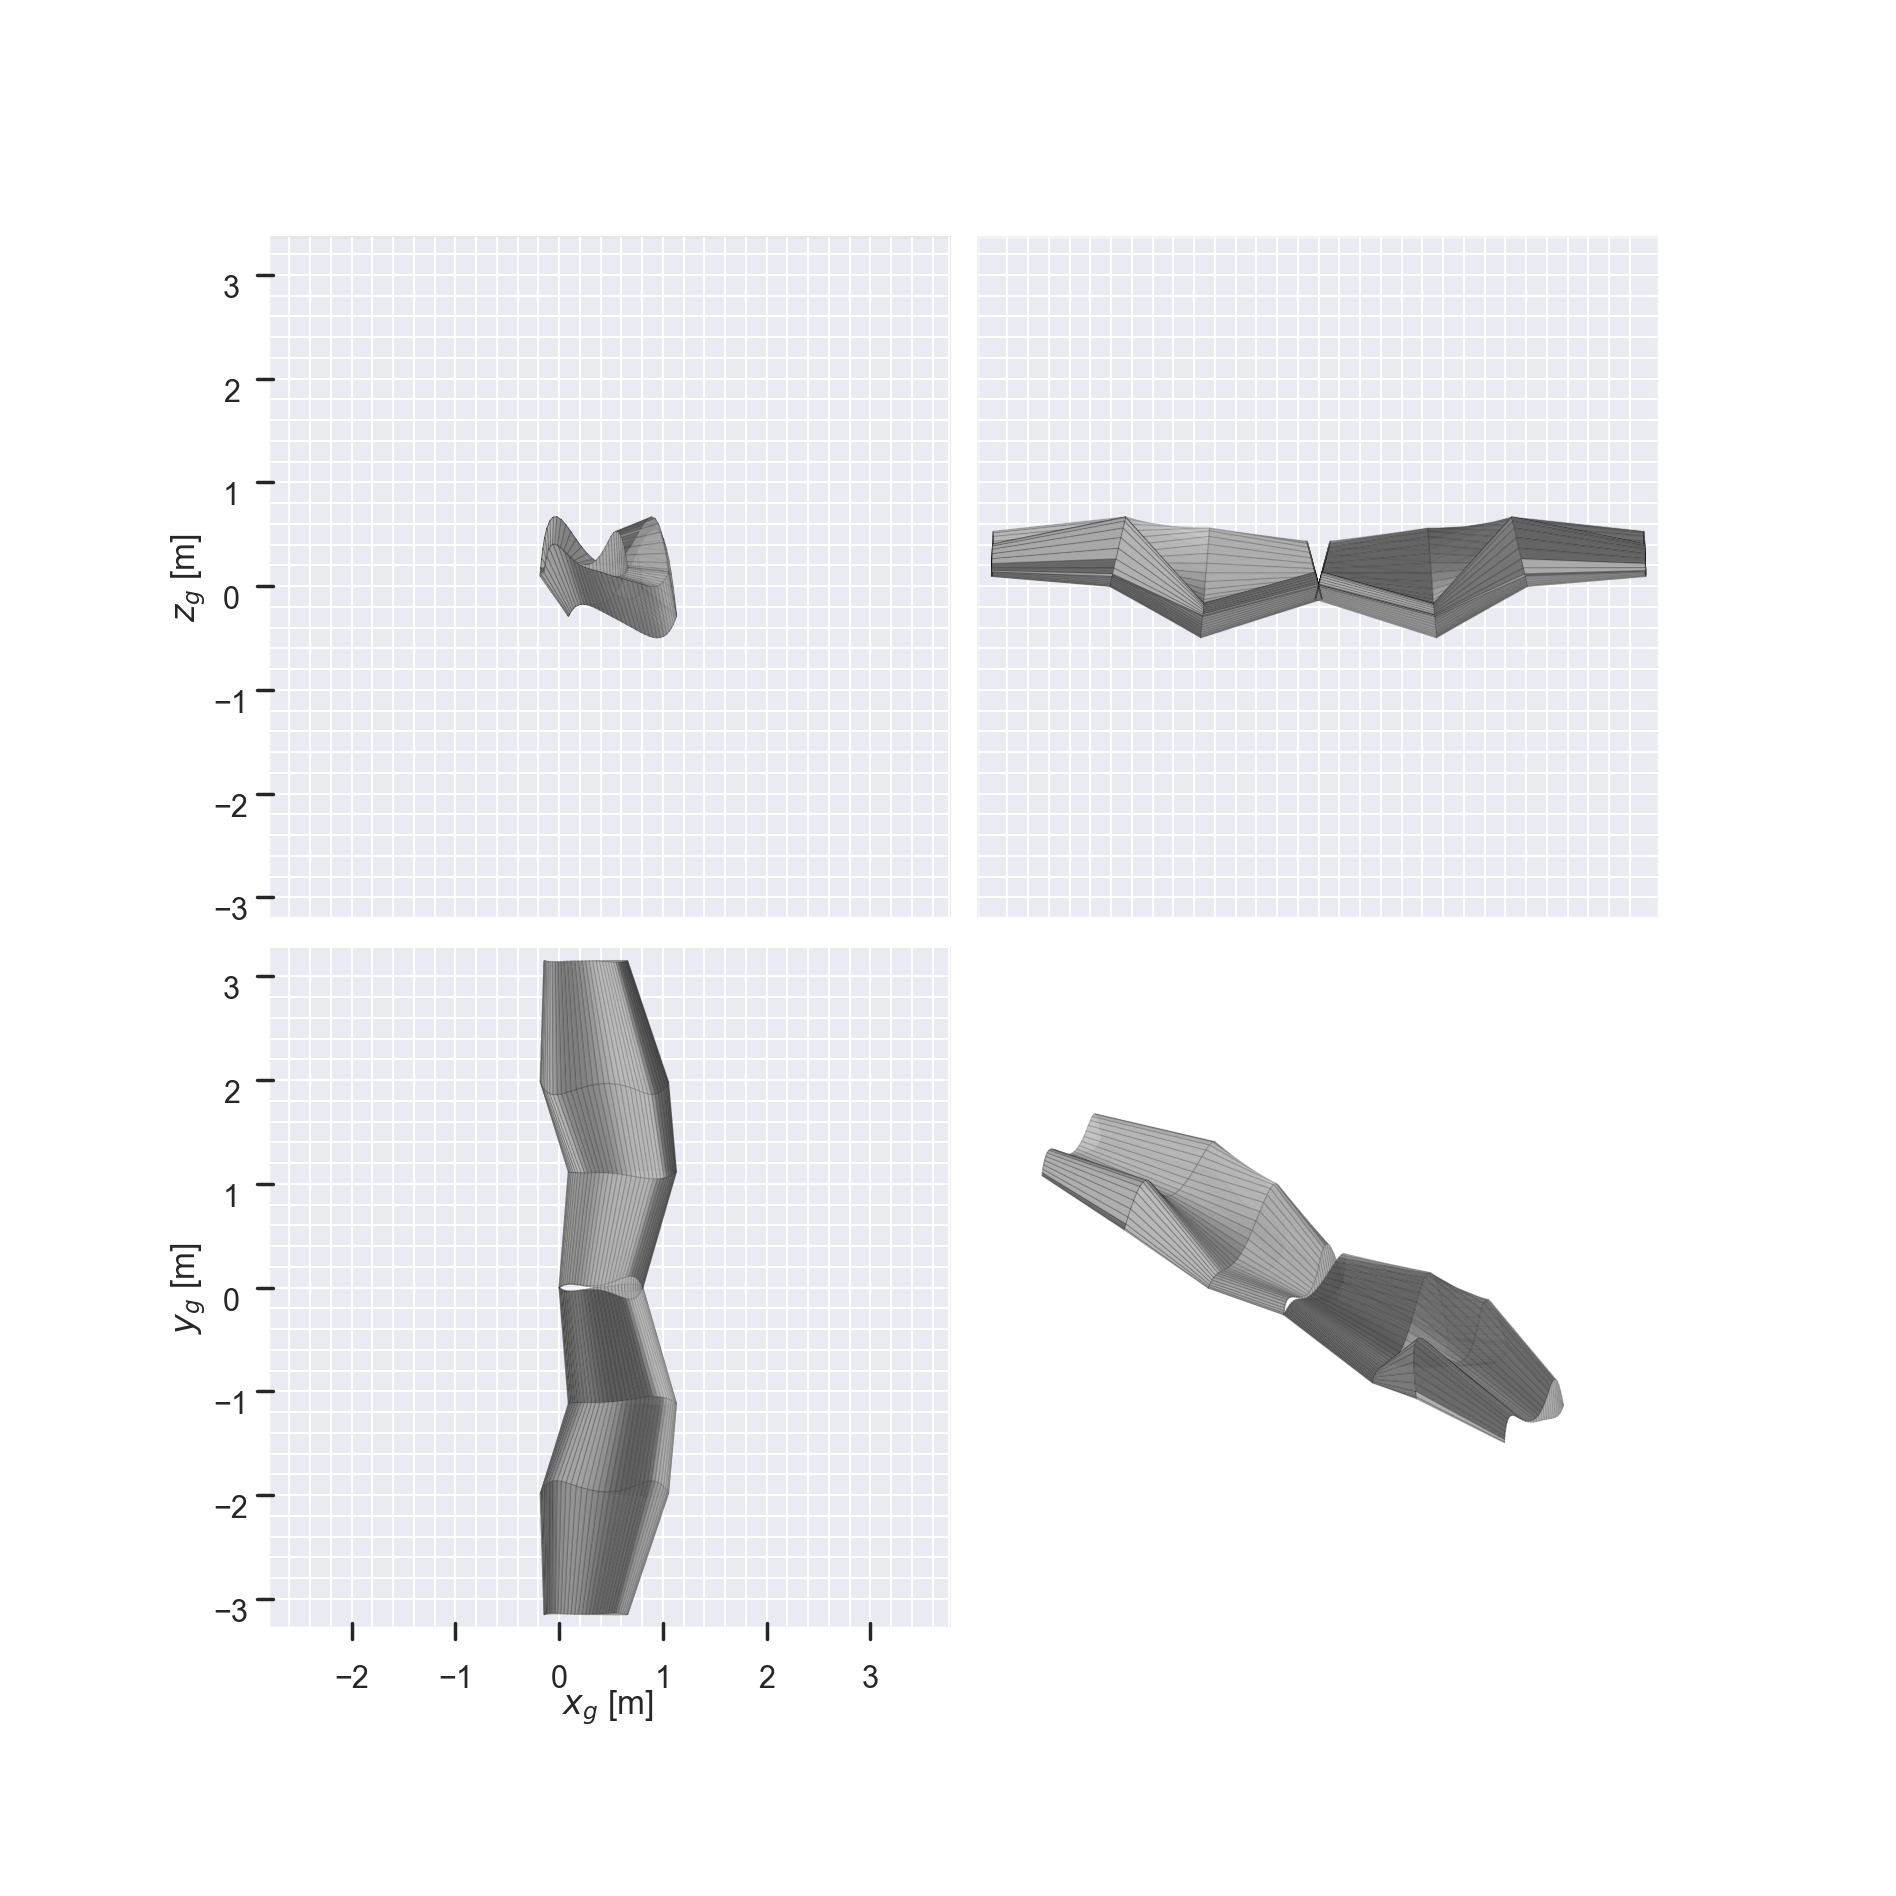

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


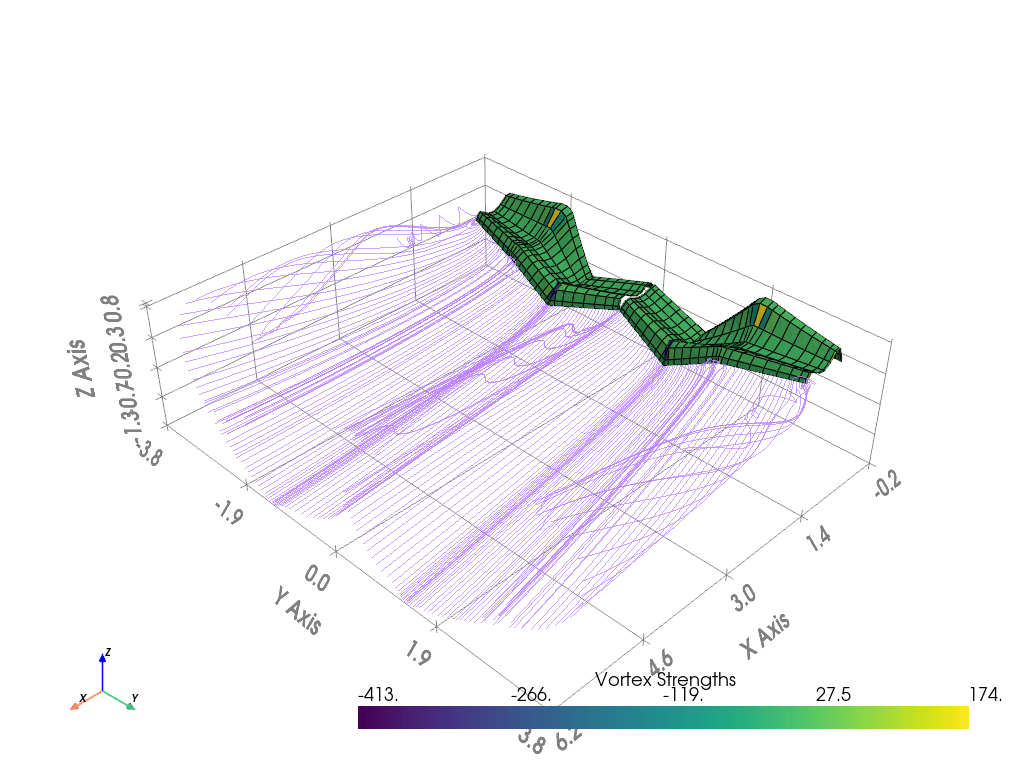

([1.5033527615595192, 0.18080348661436405], {'lift': 1.5033527615595192, 'drag': 0.18080348661436405})


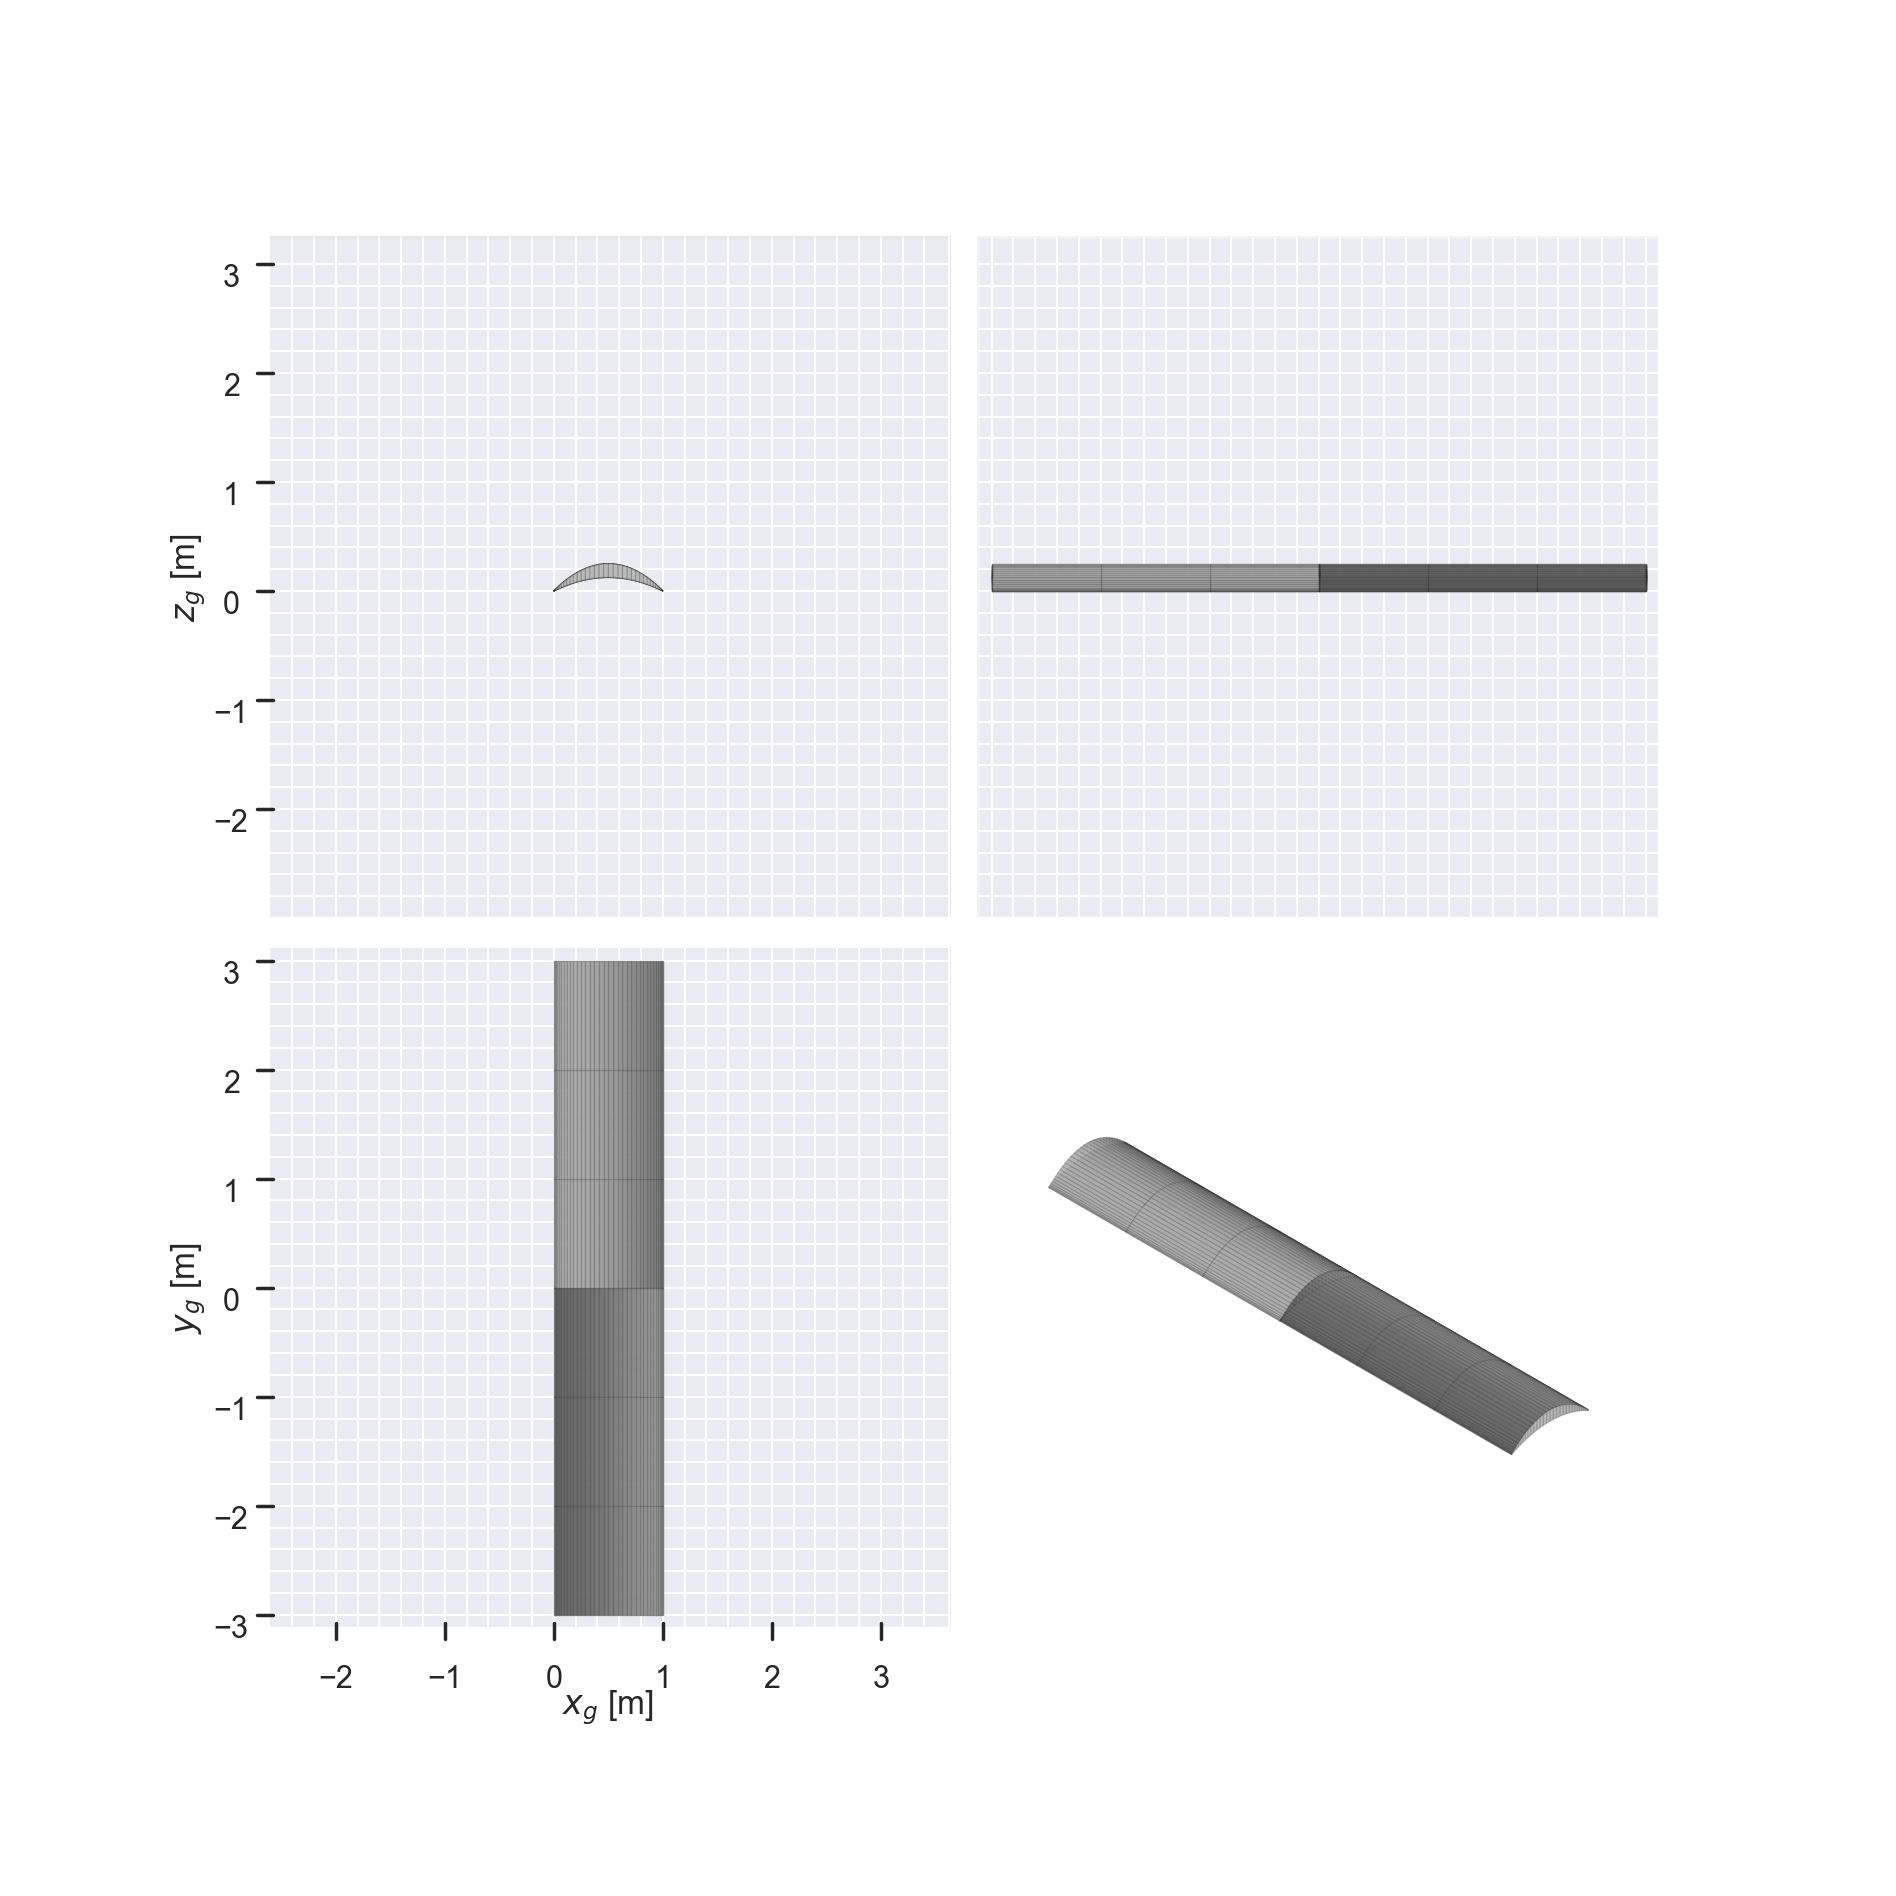

/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/Users/michaeltomadakis/Library/Python/3.9/lib/python/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


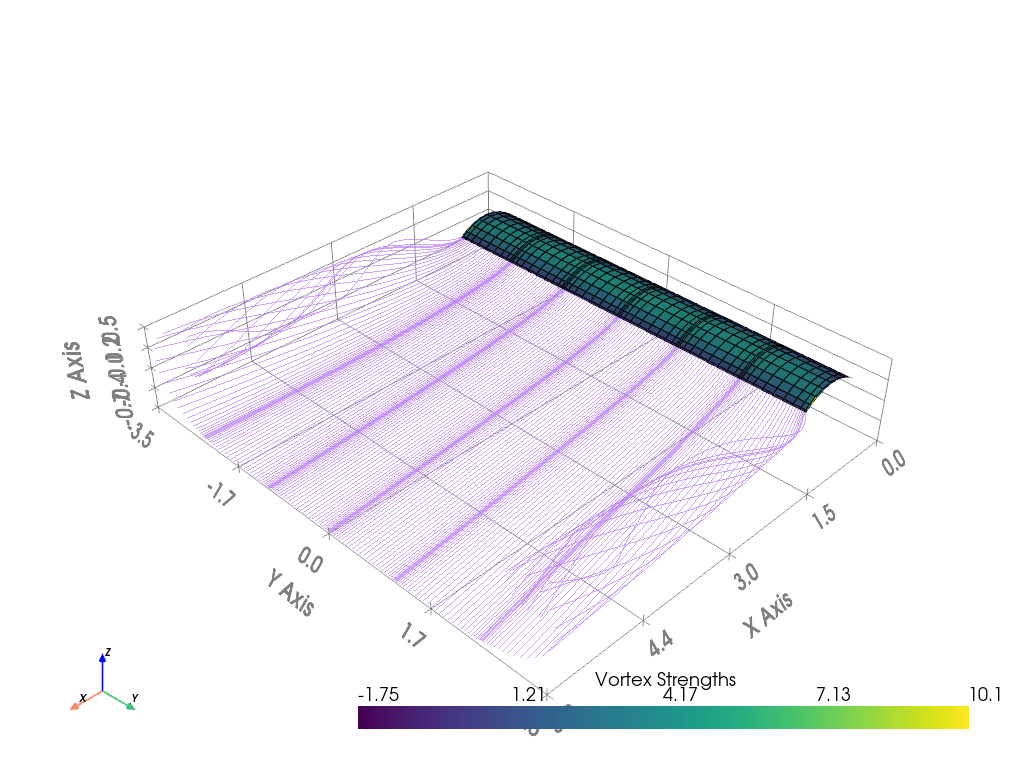

In [4]:
env = AeroEnv()
episodes = 50
obs = env.reset(123)
random_action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(random_action)
obs, reward, terminated, truncated, info = env.step(random_action)
obs, reward, terminated, truncated, info = env.step(random_action)
env.render()
print(env.reset(123))
env.render()


In [5]:
!{sys.executable} -m pip install 'stable_baselines3[extra]'

Defaulting to user installation because normal site-packages is not writeable
  Using cached Shimmy-1.1.0-py3-none-any.whl (37 kB)
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 0.2.1
    Uninstalling Shimmy-0.2.1:
      Successfully uninstalled Shimmy-0.2.1
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [6]:
from stable_baselines3 import PPO
import os
import time

models_dir = f"models/A2C-{int(time.time())}"
logdir = f"logs/A2C-{int(time.time())}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

env = AeroEnv()
env.reset(123)

model = PPO("MlpPolicy", env, verbose=1)

total_timesteps = 1
model.learn(total_timesteps=total_timesteps, progress_bar=True)

print("We lerned")

num_episodes = 5
for _ in range(num_episodes):
    obs = env.reset(123)
    done = False
    while not done:
        action = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env.render()
env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

TypeError: reset() missing 1 required positional argument: 'seed'